<a href="https://colab.research.google.com/github/19marquee/rabbit-challenge/blob/main/deep-learning-2/day3section2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# レポート 深層学習day3/Section2:LSTM


## 100文字以内の要点のまとめ

- RNNの課題として時系列を遡れば遡るほど、勾配が消失するという問題がある。
- 勾配消失：誤差逆伝播法が下位層に進んで行くに連れて、勾配がどんどん緩やかになっていく。そのため、勾配降下法による更新では、下位層のパラメータはほとんど変わらず、訓練は最適解に収束しなくなる。
- LSTM：RNNモデルの構造を変えて勾配消失問題に対応。
- 勾配爆発：勾配が層を逆伝播するごとに指数関数的に大きくなっていく。
- CEC(Constant Error Carousel）：記憶機能だけを持つもの
- CECの課題：入力データについて、時間依存に関係なく一律である。この課題を解決するために、入力ゲートと出力ゲートを追加する。
- また、過去の状態がいらなくなった場合、そのタイミングで情報を忘却するために忘却ゲートを追加する。


##実装演習結果

#### 準備

#### Googleドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

#### simple RNN after
#### バイナリ加算

iters:0
Loss:2.573022499129895
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 1 0 0 0]
126 + 10 = 255
------------
iters:100
Loss:0.8524064946244583
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 1 0 0 1 1]
0 + 115 = 255
------------
iters:200
Loss:0.9406406070019078
Pred:[1 1 0 1 1 1 1 1]
True:[0 1 0 1 0 1 1 0]
40 + 46 = 223
------------
iters:300
Loss:1.0944285493736217
Pred:[1 0 0 0 0 0 1 1]
True:[1 1 0 1 1 1 1 0]
124 + 98 = 131
------------
iters:400
Loss:0.9735424515105708
Pred:[1 1 1 1 0 1 0 0]
True:[1 1 0 0 0 1 0 1]
91 + 106 = 244
------------
iters:500
Loss:1.0630068694201746
Pred:[1 1 0 0 1 0 1 0]
True:[1 0 0 1 1 1 0 1]
124 + 33 = 202
------------
iters:600
Loss:1.0784997464583486
Pred:[0 1 0 1 0 0 1 0]
True:[1 0 1 0 1 0 0 0]
123 + 45 = 82
------------
iters:700
Loss:0.9711738897491676
Pred:[0 0 1 1 1 0 1 0]
True:[0 1 1 0 1 0 0 1]
28 + 77 = 58
------------
iters:800
Loss:1.1041832177537256
Pred:[0 1 1 1 1 1 1 1]
True:[0 1 0 0 1 1 0 0]
61 + 15 = 127
------------
iters:900
Loss:1.0662915764666283
Pre

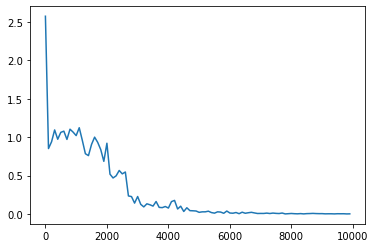

In [ ]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


#### [try] 重みの初期化方法を変更してみよう
Xavier, He

#### [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

重み初期値設定方法をHeに変更して学習

iters:0
Loss:1.1498854077628455
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 0 1 1 0]
59 + 123 = 0
------------
iters:100
Loss:1.0822152840982948
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 1 0 1 0 0]
51 + 97 = 255
------------
iters:200
Loss:0.9500714718183145
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 0 1 0 1]
59 + 10 = 0
------------
iters:300
Loss:1.0594648626221506
Pred:[0 0 0 0 0 0 0 1]
True:[1 0 1 1 0 1 0 0]
103 + 77 = 1
------------
iters:400
Loss:1.1062390020194208
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 1 1 1 1 1]
111 + 80 = 0
------------
iters:500
Loss:0.9771175504337098
Pred:[1 1 1 1 1 0 1 1]
True:[1 0 1 0 0 1 1 1]
125 + 42 = 251
------------
iters:600
Loss:1.0279257145031628
Pred:[0 1 0 0 0 0 0 1]
True:[1 0 0 0 1 1 1 1]
32 + 111 = 65
------------
iters:700
Loss:0.9840411816891219
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 1 0 1 1 1 0]
100 + 10 = 255
------------
iters:800
Loss:0.9574678534177812
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 0 1 1 0]
4 + 66 = 0
------------
iters:900
Loss:1.0067132151863933
Pred:[0 0 0

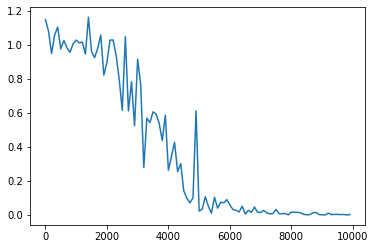

In [ ]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt


def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))
# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size)) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size)) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
#         z[:,t+1] = functions.relu(u[:,t+1])
#         z[:,t+1] = np.tanh(u[:,t+1])    
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])
#         delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])    

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

学習の進み具合は非安定的だが、lossが小さくなり学習が進んでいくことを確認。

##確認テスト

・シグモイド関数を微分した時、入力値が0の時に最大値をとる。その値として正しいものを選択肢から選べ。  
(1) 0.15  
(2) 0.25  
(3) 0.35  
(4) 0.45  

解答  
(1) 0.25

・以下の文章をLSTMに入力し空欄に当てはまる単語を予測したいとする。
文中の「とても」という言葉は空欄の予測においてなくなっても影響を及ぼさないと考えられる。  
このような場合、どのゲートが作用すると考えられるか。  

「映画おもしろかったね。ところで、とてもお腹が空いたから何か_____。」

解答  
忘却ゲート